# Estimate car price - Exploratory Data Analysis
This notebook is part of a Machine Learning project that is described and available to download on 
<BR><a href="https://blogs.sap.com/2019/11/05/hands-on-tutorial-machine-learning-push-down-to-sap-hana-with-python/">https://blogs.sap.com/2019/11/05/hands-on-tutorial-machine-learning-push-down-to-sap-hana-with-python/</a>
<BR><BR>The purpose of this notebook is for a Data Scientist to explore and understand the historic data, which will be used to train a regression model. Based on the finding the dataset will be slightly reduced to avoid outliers (old and / or expensive cars) unduly affecting the model.

### Steps in this notebook
-  Connect to SAP HANA
-  Create a SAP HANA DataFrame which points to the data
-  Take a more detailed look at the data
-  Remove old and expensive cars, save the reduced data as view in SAP HANA

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/2cfbc5cf2bc14f028cfbe2a2bba60a50/latest/en-US/f652a8186a144e929a1ade7a3cb7abe8.html
-  Dataset: https://www.kaggle.com/bozungu/ebay-used-car-sales-data

### Create a SAP HANA DataFrame, which points to the training data
Instantiate a connecton object to SAP HANA.
-  For simplicity, to help you get started, these values are hardcoded here. 
-  We recommend keeping these credentials in the Secure User Store of the SAP HANA Client. Retrieving the credentials from the Secure User Store prevents having to specify these credentials in clear text. See the blog on the SAP Commmunity to which these notebooks belong, for steps on how to use that Secure User Store.

In [1]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(userkey = 'hana_hxe', encrypt = 'true', sslValidateCertificate = 'false')

Create the SAP HANA DataFrame, which points to the table with historic sales. No data is extracted.

In [2]:
df_remote = conn.table(table = 'USEDCARPRICES')

### Peek at the data and retrieve a small number of rows

In [3]:
df_remote.head(5).collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE,PRICE
0,0,bus,2004,manual,102,A-Class,150000,petrol,1850
1,1,limousine,1995,automatic,113,E-Class,150000,diesel,3300
2,2,limousine,2004,automatic,122,E-Class,150000,diesel,3500
3,3,bus,1984,manual,70,Other,150000,diesel,1500
4,4,bus,2012,automatic,109,B-Class,150000,diesel,13500


### Row count
Retrieve the number of rows / observations in the dataset.

In [4]:
df_remote.count()

26900

### Column maximum
Various functions on the SAP HANA DataFrame allow to push calculation down to SAP HANA. Have SAP HANA find the most expensive car in the dataset.

In [5]:
df_remote.agg([('max', 'PRICE', 'MOSTEXPENSIVE')]).collect()

,MOSTEXPENSIVE
0,14000500


### Descriptive statistics 
Display most important data column statistics. All values were calculated within SAP HANA. Notice how some columns have null values. These are rows with missing values.

In [6]:
df_remote.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CAR_ID,26900,26900,0,13449.500000,7765.505456,0.0,26899.0,13450.0,6724.75,6724.0,13449.5,13449.0,20174.25,20174.0
1,YEAR,26900,74,0,2003.002342,31.352876,1000.0,6200.0,2003.0,1999.00,1999.0,2003.0,2003.0,2008.00,2008.0
2,HP,26900,307,0,163.146171,212.759225,0.0,20000.0,150.0,122.00,122.0,150.0,150.0,193.00,193.0
3,KILOMETER,26900,13,0,129136.059480,36850.310065,5000.0,150000.0,150000.0,125000.00,125000.0,150000.0,150000.0,150000.00,150000.0
4,PRICE,26900,1972,0,10078.361970,86154.852061,0.0,14000500.0,6000.0,2800.00,2800.0,6000.0,6000.0,12887.25,12887.0
5,VEHICLETYPE,25899,8,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GEARBOX,26396,2,504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MODEL,26381,18,519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,FUELTYPE,25930,7,970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Display the SELECT statement that was automatically created to obtain the above statistics. The syntax might be useful for transparency, verification or modification.

In [7]:
df_remote.describe().select_statement

'SELECT * FROM (SELECT "SimpleStats".*, "Percentiles"."25_percent_cont", "Percentiles"."25_percent_disc", "Percentiles"."50_percent_cont", "Percentiles"."50_percent_disc", "Percentiles"."75_percent_cont", "Percentiles"."75_percent_disc" FROM (select \'CAR_ID\' as "column", COUNT("CAR_ID") as "count", COUNT(DISTINCT "CAR_ID") as "unique", SUM(CASE WHEN "CAR_ID" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("CAR_ID")) as "mean", STDDEV("CAR_ID") as "std", MIN("CAR_ID") as "min", MAX("CAR_ID") as "max", MEDIAN("CAR_ID") as "median" FROM (SELECT * FROM "USEDCARPRICES") AS "DT_0" UNION ALL select \'YEAR\' as "column", COUNT("YEAR") as "count", COUNT(DISTINCT "YEAR") as "unique", SUM(CASE WHEN "YEAR" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("YEAR")) as "mean", STDDEV("YEAR") as "std", MIN("YEAR") as "min", MAX("YEAR") as "max", MEDIAN("YEAR") as "median" FROM (SELECT * FROM "USEDCARPRICES") AS "DT_0" UNION ALL select \'HP\' as "column", COUNT("HP") as "count", COUNT(DISTIN

### Category frequency by Model
In the previous notebook the hana_ml wrapper was used to plot the number of cars by model. To have more control over the plot one can also delegate the aggregation / count to SAP HANA, retrieve the result as pandas data frame and create a plot from scratch.
<BR><BR>Plot only the top N models.

In [8]:
top_n = 5
df_remote_col_frequency = df_remote.agg([('count', 'MODEL', 'COUNT')],  group_by = 'MODEL')
df_col_frequency = df_remote_col_frequency.sort('COUNT', desc = True).head(top_n).collect()
df_col_frequency

,MODEL,COUNT
0,C-Class,6845
1,E-Class,5615
2,A-Class,3153
3,Other,2710
4,CLK,1447


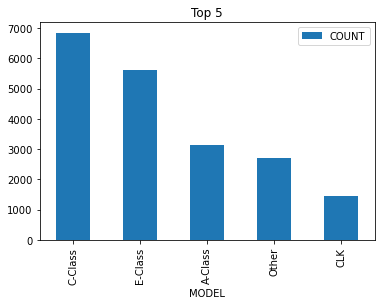

In [9]:
%matplotlib inline
df_col_frequency.plot.bar(x = 'MODEL',
                          y = 'COUNT',
                          title = 'Top ' + str(top_n));

### Inspect price against year on sample data
Retrieve 1% of the full data set as sample

In [10]:
from hana_ml.algorithms.pal import partition
df_remote_sample, df_remote_ignore1, df_remote_ignore2 = partition.train_test_val_split(
                               data = df_remote, 
                               random_seed = 4242,
                               training_percentage = 0.01, 
                               testing_percentage = 0.99, 
                               validation_percentage = 0)

In [11]:
df_remote_sample.head(5).collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE,PRICE
0,14,limousine,2007,automatic,170,C-Class,125000,diesel,14499
1,201,coupe,2011,automatic,204,C-Class,150000,diesel,17999
2,312,cabrio,2004,manual,272,SLK,150000,petrol,12400
3,364,coupe,2008,automatic,150,C-Class,150000,diesel,9250
4,401,limousine,2003,manual,177,E-Class,150000,petrol,5749


Reduce the sample data to the two numerical columns and retrieve the data as pandas data frame.

In [12]:
col_name_1 = 'PRICE'
col_name_2 = 'YEAR'
df_sample = df_remote_sample.select(col_name_1, col_name_2).collect()

Visualise the two sampled columns in a scatter plot. The internal code of the plot might display a FutureWarning. This warning can be ignored.

In [13]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)

Install the seaborn library that will be needed for the charting. 
<BR>Once the library is installed, the command can be de-activated by adding a # in front. This character thurs the code into a comment.

In [14]:
!pip install seaborn

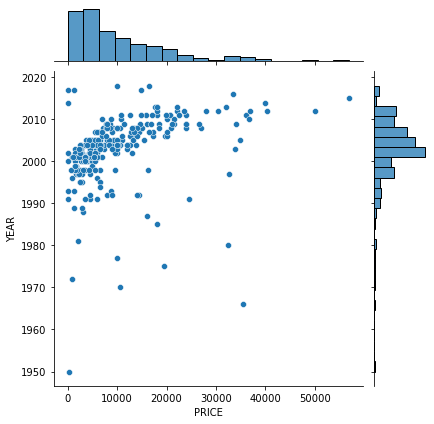

In [15]:
%matplotlib inline
import seaborn as sns
sns.jointplot(x=col_name_1, y=col_name_2, data=df_sample);

### Display outliers
List the most expensive vehicles.

In [16]:
df_remote.filter('PRICE > 200000').sort('PRICE', desc=True).collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE,PRICE
0,20301,coupe,2008,automatic,231,CLK,125000,petrol,14000500
1,9924,cabrio,1960,manual,160,Other,5000,petrol,585000
2,24460,cabrio,2010,automatic,625,Other,30000,petrol,368000
3,24002,limousine,2009,automatic,457,C-Class,100000,petrol,350000
4,21030,cabrio,1934,manual,60,Other,150000,None,275000
5,15944,cabrio,2013,automatic,571,Other,10000,petrol,237500
6,8778,coupe,2010,automatic,571,Other,10000,petrol,225000
7,6361,coupe,2010,automatic,571,Other,50000,petrol,214800
8,10476,coupe,2011,automatic,571,Other,50000,petrol,205000
9,23090,cabrio,1952,manual,116,Other,100000,petrol,205000


### Save outliers to file
Write the above list to CSV file.

In [17]:
df_outliers = df_remote.filter('PRICE > 200000').sort('PRICE', desc = True).collect()
df_outliers.to_csv('most_expensive_cars.csv', sep=';' ,  index = False)

### Focus the dataset
Filter on cars built from the year 2000 onwards costing under 50k Euro. Separate Machine Learning models could be created later for the more unusual cars, ie the most expensive ones or the oldtimers. Show how many vehicles remain in the dataset.

In [18]:
df_remote = df_remote.filter('YEAR >= 2000')
df_remote = df_remote.filter('PRICE < 50000')
df_remote.count()

19800

### Correlations
For the final dataset show the correlations between the numerical columns. The strongest negative correlation is between Kilometer and Price. The strongest positive correlation is between horsepower and price. This means in tendency, the more horsepower and the lower the mileage, the higher the price.
<BR>Depending on the version of your Matplotlib package you might see a deprecation warning. This is not an error.

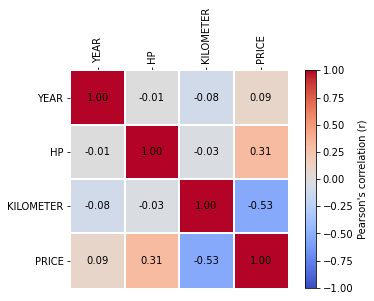

In [19]:
import matplotlib.pyplot as plt
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure()
ax1 = f.add_subplot(111) # 111 refers to 1x1 grid, 1st subplot
eda = EDAVisualizer(ax1)
ax, corr_data = eda.correlation_plot(data = df_remote.drop(['CAR_ID']),
                                     cmap = 'coolwarm')

### Change column type of the target
Currently the type of the target column PRICE is not supported by the algorithm we want to use in the next notebook. Change the type now before changing this view of the data, so that all subsequent steps benefit from this change.

In [20]:
df_remote = df_remote.cast('PRICE', 'DOUBLE')

### Save filtered dataset as view
In this notebook the dataset was reduced by filtering on the price and year of the car. Persist this adjusted dataset as view, so that subsequent notebooks can access this filtered data, without having to duplicate the data in another table. 

In [21]:
df_remote_result = df_remote.save(where = 'USEDCARPRICES_TOTRAIN', table_type = 'VIEW', force = True)

### Close connection

In [22]:
conn.close()